# Indicadores de análise de ações

* Lucro por Ação (LPA) $$LPA = \dfrac{Lucro\ Líquido}{Número\ de\ ações\ emitidas}$$

* Preço/Lucro (P/L) $$P/L = \dfrac{Preço\ de\ Mercado\ da\ Ação}{LPA}$$

In [1]:
import os
import re
import unidecode
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import scipy.stats as stats

plt.style.use('seaborn')
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = "14"

In [2]:
def secure_name(string):
    """
    Remove caracteres especiais de uma string
    """
    pattern = r'[^A-Za-z0-9_]+'
    output_string = string.replace(' ', '_').lower()
    output_string = unidecode.unidecode(output_string)
    output_string = re.sub(pattern, '', output_string)
    return output_string

In [3]:
ROOT_DIR = os.getcwd().replace('src', '')

In [4]:
novo_mercado = pd.read_csv(os.path.join(ROOT_DIR, 'data', 'sample_market-2022-09-15.csv'))
novo_mercado.head()

,Nome Do Pregão,Código,Denominação Social,Segmento De Mercado,Tipo De Capital,Capital R$,Aprovado Em,Qtde Ações Ordinárias,Qtde Ações Preferenciais,Qtde Total De Ações,CNPJ,Código CVM,Ticker,Atividade Principal,Setor Econômico,Subsetor Econômico,Segmento Econômico,Site,Url
0,ATMASA,ATMP,ATMA PARTICIPAÇÕES S.A.,NOVO MERCADO,Homologado,1.419403e+09,15/12/2021,26710356,0,26710356,04.032.433/0001-80,19100,ATMP3.SA,A ATMA Participações S.A. tem como objeto soci...,Bens Industriais,Serviços,Serviços Diversos,www.liq.com.br,https://sistemaswebb3-listados.b3.com.br/liste...
1,CCR SA,CCRO,CCR S.A.,NOVO MERCADO,Homologado,6.126100e+09,09/02/2017,2020000000,0,2020000000,02.846.056/0001-97,18821,CCRO3.SA,Prestadora de serviços públicos por meio de co...,Bens Industriais,Transporte,Exploração de Rodovias,www.ccr.com.br,https://sistemaswebb3-listados.b3.com.br/liste...
2,ECORODOVIAS,ECOR,ECORODOVIAS INFRAESTRUTURA E LOGÍSTICA S.A.,NOVO MERCADO,Homologado,2.101489e+09,23/06/2021,696334224,0,696334224,04.149.454/0001-80,19453,ECOR3.SA,Exploração direta ou indireta de negócios de c...,Bens Industriais,Transporte,Exploração de Rodovias,www.ecorodovias.com.br,https://sistemaswebb3-listados.b3.com.br/liste...
3,EMBRAER,EMBR,EMBRAER S.A.,NOVO MERCADO,Homologado,5.159617e+09,05/03/2018,740465044,0,740465044,07.689.002/0001-89,20087,EMBR3.SA,Projeto. desenvolvimento. fabricação. comercia...,Bens Industriais,Material de Transporte,Material Aeronáutico e de Defesa,www.embraer.com.br,https://sistemaswebb3-listados.b3.com.br/liste...
4,ETERNIT,ETER,ETERNIT S.A.,NOVO MERCADO,Homologado,4.380815e+08,29/09/2021,61776575,0,61776575,61.092.037/0001-81,5762,ETER3.SA,Industrialização e comercialização de produtos...,Bens Industriais,Construção e Engenharia,Produtos para Construção,www.eternit.com.br/ri,https://sistemaswebb3-listados.b3.com.br/liste...


In [5]:
setores = novo_mercado['Setor Econômico'].drop_duplicates().to_list()
setores

['Bens Industriais',
 'Comunicações',
 'Consumo Cíclico',
 'Consumo não Cíclico',
 'Financeiro',
 'Materiais Básicos',
 'Petróleo. Gás e Biocombustíveis',
 'Saúde',
 'Tecnologia da Informação',
 'Utilidade Pública']

In [6]:
dfcs_nomes = ['BPA_con', 'BPP_con', 'DRE_con']
dfcs = pd.DataFrame()
for nome in dfcs_nomes:
    for tipo in ['itr', 'dfp']:
        tmp = pd.read_csv(os.path.join(ROOT_DIR, 'data', 'dfcs', f'{tipo}_cia_aberta_{nome}_2017-2021.csv'))
        dfcs = pd.concat([dfcs, tmp])
    
dfcs = dfcs[dfcs['ORDEM_EXERC']=='ÚLTIMO']
dfcs = dfcs[['DT_REFER', 'DENOM_CIA', 'CNPJ_CIA', 'CD_CVM', 'CD_CONTA', 'DS_CONTA', 'VL_CONTA']]
dfcs['DT_REFER'] = pd.to_datetime(dfcs['DT_REFER'])
dfcs = dfcs[dfcs['CD_CONTA'].apply(lambda x: len(x) <= 10)]
dfcs.reset_index(drop=True, inplace=True)
dfcs = dfcs.sort_values(['DENOM_CIA', 'DT_REFER'])
dfcs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1204819 entries, 251943 to 1195523
Data columns (total 7 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   DT_REFER   1204819 non-null  datetime64[ns]
 1   DENOM_CIA  1204819 non-null  object        
 2   CNPJ_CIA   1204819 non-null  object        
 3   CD_CVM     1204819 non-null  int64         
 4   CD_CONTA   1204819 non-null  object        
 5   DS_CONTA   1204819 non-null  object        
 6   VL_CONTA   1204819 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 73.5+ MB


In [7]:
dfcs.head()

,DT_REFER,DENOM_CIA,CNPJ_CIA,CD_CVM,CD_CONTA,DS_CONTA,VL_CONTA
251943,2019-12-31,2W ENERGIA S.A.,08.773.135/0001-00,25224,1,Ativo Total,424330.0
251944,2019-12-31,2W ENERGIA S.A.,08.773.135/0001-00,25224,1.01,Ativo Circulante,286849.0
251945,2019-12-31,2W ENERGIA S.A.,08.773.135/0001-00,25224,1.01.01,Caixa e Equivalentes de Caixa,11588.0
251946,2019-12-31,2W ENERGIA S.A.,08.773.135/0001-00,25224,1.01.02,Aplicações Financeiras,0.0
251947,2019-12-31,2W ENERGIA S.A.,08.773.135/0001-00,25224,1.01.02.01,Aplicações Financeiras Avaliadas a Valor Justo...,0.0


In [8]:
contas = dfcs[dfcs['CD_CVM']==25224]
contas = contas[['CD_CONTA', 'DS_CONTA']].drop_duplicates()

display(contas[:51])
display(contas[51:100])
display(contas[100:])

,CD_CONTA,DS_CONTA
251943,1,Ativo Total
251944,1.01,Ativo Circulante
251945,1.01.01,Caixa e Equivalentes de Caixa
251946,1.01.02,Aplicações Financeiras
251947,1.01.02.01,Aplicações Financeiras Avaliadas a Valor Justo...
251948,1.01.02.02,Aplicações Financeiras Avaliadas a Valor Justo...
251949,1.01.02.03,Aplicações Financeiras Avaliadas ao Custo Amor...
251950,1.01.03,Contas a Receber
251951,1.01.03.01,Clientes
251952,1.01.03.02,Outras Contas a Receber


,CD_CONTA,DS_CONTA
737805,2.01.03.02,Obrigações Fiscais Estaduais
737806,2.01.03.03,Obrigações Fiscais Municipais
737807,2.01.04,Empréstimos e Financiamentos
737808,2.01.04.01,Empréstimos e Financiamentos
737809,2.01.04.02,Debêntures
737810,2.01.04.03,Financiamento por Arrendamento
737811,2.01.05,Outras Obrigações
737812,2.01.05.01,Passivos com Partes Relacionadas
737813,2.01.05.02,Outros
737814,2.01.06,Provisões


,CD_CONTA,DS_CONTA
737854,2.03.04.02,Reserva Estatutária
737855,2.03.04.03,Reserva para Contingências
737856,2.03.04.04,Reserva de Lucros a Realizar
737857,2.03.04.05,Reserva de Retenção de Lucros
737858,2.03.04.06,Reserva Especial para Dividendos Não Distribuídos
737859,2.03.04.07,Reserva de Incentivos Fiscais
737860,2.03.04.08,Dividendo Adicional Proposto
737861,2.03.04.09,Ações em Tesouraria
737862,2.03.05,Lucros/Prejuízos Acumulados
737863,2.03.06,Ajustes de Avaliação Patrimonial


In [9]:
def calcula_lpa(x):
    LPA = 1000* x[x['CD_CONTA']=='3.99.01.01'].iloc[0]['VL_CONTA'] # Lucro por Ação
    
    
    return pd.Series([LPA], index=['LPA'])

In [10]:
def calcula_lpa_setorial(dfcs, setor, nome=None):
    lpa_empresas = {}

    for cd_cvm in setor['Código CVM'].to_list():
        try:
            empresa = dfcs[dfcs['CD_CVM']==cd_cvm].reset_index(drop=True)
            if nome=='Comunicações':#17639 -> Tim participações
                empresa = dfcs[dfcs['CD_CVM'].isin([cd_cvm, 17639])].reset_index(drop=True)
            empresa = empresa[empresa['CD_CONTA'].apply(lambda x: len(x) <= 10)]
            #empresa = calcula_vl_conta_medio(empresa, '1')
            #empresa = calcula_vl_conta_medio(empresa, '2.03')
            lpa = empresa.groupby('DT_REFER').apply(calcula_lpa)
            lpa.index = pd.PeriodIndex(lpa.index, freq='Q')
            lpa_empresas[cd_cvm] = lpa
        except:
            lpa_empresas[cd_cvm] = pd.DataFrame()

    lpa_setorial = pd.DataFrame()
    for cd_cvm, lpa in lpa_empresas.items():
        peso = setor[setor['Código CVM']==cd_cvm]['Peso Capital Social'].reset_index(drop=True)
        peso = peso[0]
        lpa_setorial = lpa_setorial.add(peso * lpa, fill_value=0)
        
    lpa_setorial.to_csv(os.path.join(ROOT_DIR, 'data', 'indicadores', f'lpa_{secure_name(nome)}.csv'))

    return lpa_setorial

In [48]:
def plot_lpa(lpa_setorial, nome=None):
    lpa_setorial = lpa_setorial['2018-01-01':]
    tidy = lpa_setorial.reset_index()
    
    #tidy = pd.melt(lpa_setorial.reset_index(), id_vars='DT_REFER', value_vars=['LPA'])
    tidy.columns=['Trimestre', 'Valor']

    fig, ax = plt.subplots(figsize=(20, 6))
    sns.barplot(data=tidy, x='Trimestre', y='Valor', ax=ax, color='royalblue')
    #ax.set_ylim([int(endividamento_setorial.min().min()) - 1, 1.5 + int(endividamento_setorial.max().max())])

    ax.set_ylabel('LPA', fontweight='bold')
    ax.set_xlabel('Trimestre', fontweight='bold')
    
    plt.savefig(os.path.join(ROOT_DIR, 'img', 'indicadores', f'lpa_{secure_name(nome)}.png'), bbox_inches='tight')

    plt.show()

In [49]:
def calcula_lpa_teste_bootstrap(lpa_setorial, nome=None):
    lpa_setorial = lpa_setorial['2018-01-01':]
    lpa_prepandemia = lpa_setorial[:'2019-12-31']
    lpa_pandemia = lpa_setorial['2020-01-01':]
    
    lpa_prepandemia_lst = np.array([np.mean(np.random.choice(lpa_prepandemia['LPA'].to_numpy(), 8)) for _ in range(100)])
    lpa_prepandemia = pd.DataFrame(lpa_prepandemia_lst, columns=lpa_prepandemia.columns)
    
    lpa_pandemia_lst = np.array([np.mean(np.random.choice(lpa_pandemia['LPA'].to_numpy(), 8)) for _ in range(100)])
    lpa_pandemia = pd.DataFrame(lpa_pandemia_lst, columns=lpa_pandemia.columns)


    lpa_prepandemia_stats = lpa_prepandemia.describe().drop(['count'], axis=0)
    lpa_prepandemia_stats.to_csv(os.path.join(ROOT_DIR, 'data', 'indicadores', f'lpa_{secure_name(nome)}_prepandemia_stats.csv'))
    print('Estatísticas Descritivas - Pré-pandemia')
    display(lpa_prepandemia_stats)
    
    
    lpa_pandemia_stats = lpa_pandemia.describe().drop(['count'], axis=0)
    lpa_pandemia_stats.to_csv(os.path.join(ROOT_DIR, 'data', 'indicadores', f'lpa_{secure_name(nome)}_pandemia_stats.csv'))
    print('Estatísticas Descritivas - Pandemia')
    display(lpa_pandemia_stats)
    
    
    cols = ['LPA', 'Teste', 'Estatística', 'Valor p']
    lpa_stats = pd.DataFrame(columns=cols)
    for lpa in lpa_setorial.columns:

        group1, group2 = lpa_prepandemia[lpa].to_numpy(), lpa_pandemia[lpa].to_numpy()
        ttest= stats.ttest_rel(a=group1, b=group2)
        htest = stats.kruskal(group1, group2)

        dft = pd.DataFrame([lpa, 'Teste t', ttest.statistic, ttest.pvalue]).T
        dfh = pd.DataFrame([lpa, 'Teste H', htest.statistic, htest.pvalue]).T

        dft.columns = cols
        dfh.columns = cols

        lpa_stats = pd.concat([lpa_stats, dft, dfh])

    lpa_stats.reset_index(drop=True, inplace=True)
    lpa_stats.to_csv(os.path.join(ROOT_DIR, 'data', 'indicadores', f'lpa_{secure_name(nome)}_teste_bootstrapl.csv'), index=False)
    
    return lpa_stats

In [50]:
def lista_setores():
    setores_dict = {}
    for setor_nome in novo_mercado['Setor Econômico'].drop_duplicates().to_list():
        setor_df = novo_mercado[novo_mercado['Setor Econômico']==setor_nome]\
            .sort_values(by=['Capital R$'], ascending=False)\
            .reset_index(drop=True)
        setor_df['Peso Capital Social'] = setor_df['Capital R$'] / setor_df['Capital R$'].sum()
        
        setores_dict[setor_nome] = setor_df[['Denominação Social', 'Código CVM', 'Ticker', 'Capital R$', 'Peso Capital Social']]
        
    return setores_dict

## Análise dos setores


 BENS INDUSTRIAIS
1) LPA Setorial


,LPA
DT_REFER,
2018Q1,-404.414175
2018Q2,49.503648
2018Q3,-853.741001
2018Q4,-718.002724
2019Q1,-20.882583
2019Q2,-70.942593
2019Q3,-39.894663
2019Q4,-6573.582704
2020Q1,-317.171653


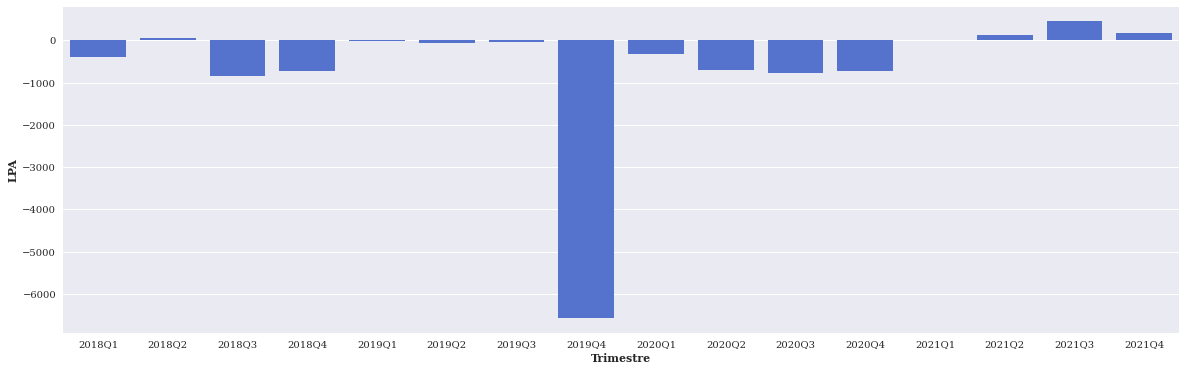

2) Testes de Hipótese
Estatísticas Descritivas - Pré-pandemia


,LPA
mean,-1083.657103
std,766.663851
min,-3544.590418
25%,-1242.143586
50%,-1030.411071
75%,-400.700209
max,-40.527116


Estatísticas Descritivas - Pandemia


,LPA
mean,-209.218801
std,169.459995
min,-546.916269
25%,-328.971987
50%,-227.200029
75%,-80.003414
max,208.881522


,LPA,Teste,Estatística,Valor p
0,LPA,Teste t,-11.027772,0.0
1,LPA,Teste H,89.645724,0.0



 COMUNICAÇÕES
1) LPA Setorial


""



 CONSUMO CÍCLICO
1) LPA Setorial


,LPA
DT_REFER,
2018Q1,-4.148337e+02
2018Q2,-6.880693e+02
2018Q3,-9.328469e+02
2018Q4,1.470341e+03
2019Q1,-1.414233e+03
2019Q2,-2.753507e+03
2019Q3,-3.998300e+03
2019Q4,-5.687819e+03
2020Q1,-1.372669e+03


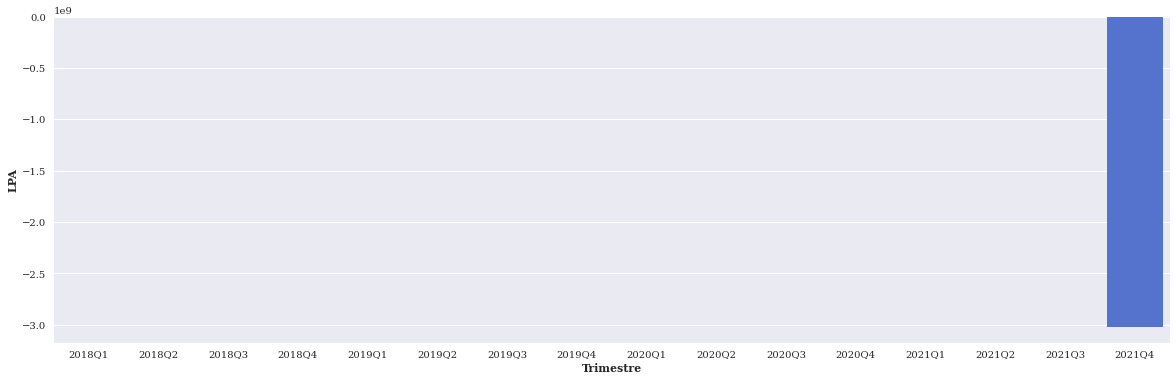

2) Testes de Hipótese
Estatísticas Descritivas - Pré-pandemia


,LPA
mean,-1820.347698
std,772.381162
min,-3813.860880
25%,-2289.932120
50%,-1808.144215
75%,-1290.868353
max,-99.133429


Estatísticas Descritivas - Pandemia


,LPA
mean,-3.326017e+08
std,3.409427e+08
min,-1.511819e+09
25%,-3.779566e+08
50%,-3.779559e+08
75%,-1.924055e+03
max,-1.330148e+03


,LPA,Teste,Estatística,Valor p
0,LPA,Teste t,9.755297,0.0
1,LPA,Teste H,59.427193,0.0



 CONSUMO NÃO CÍCLICO
1) LPA Setorial


,LPA
DT_REFER,
2018Q1,232.990275
2018Q2,-153.709872
2018Q3,-279.073296
2018Q4,-399.040145
2019Q1,102.672296
2019Q2,555.400669
2019Q3,691.622565
2019Q4,1351.058646
2020Q1,-630.794823


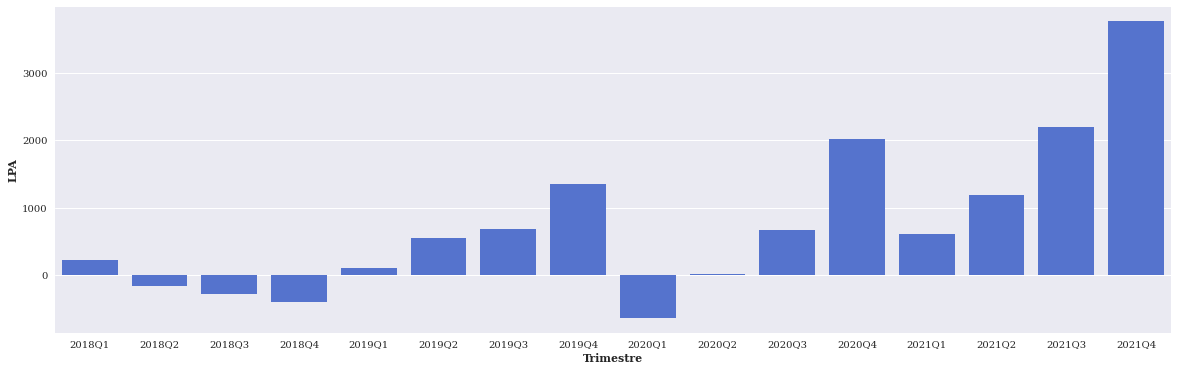

2) Testes de Hipótese
Estatísticas Descritivas - Pré-pandemia


,LPA
mean,282.423417
std,202.714283
min,-93.648937
25%,104.753629
50%,301.262388
75%,387.088069
max,842.674587


Estatísticas Descritivas - Pandemia


,LPA
mean,1296.067713
std,467.474424
min,393.049669
25%,1051.276768
50%,1271.857731
75%,1517.465672
max,2445.294541


,LPA,Teste,Estatística,Valor p
0,LPA,Teste t,-20.890054,0.0
1,LPA,Teste H,139.3928,0.0



 FINANCEIRO
1) LPA Setorial


,LPA
DT_REFER,
2018Q1,317.047758
2018Q2,714.730922
2018Q3,1038.304679
2018Q4,1545.662317
2019Q1,317.712195
2019Q2,733.769298
2019Q3,977.371141
2019Q4,1427.035328
2020Q1,256.861828


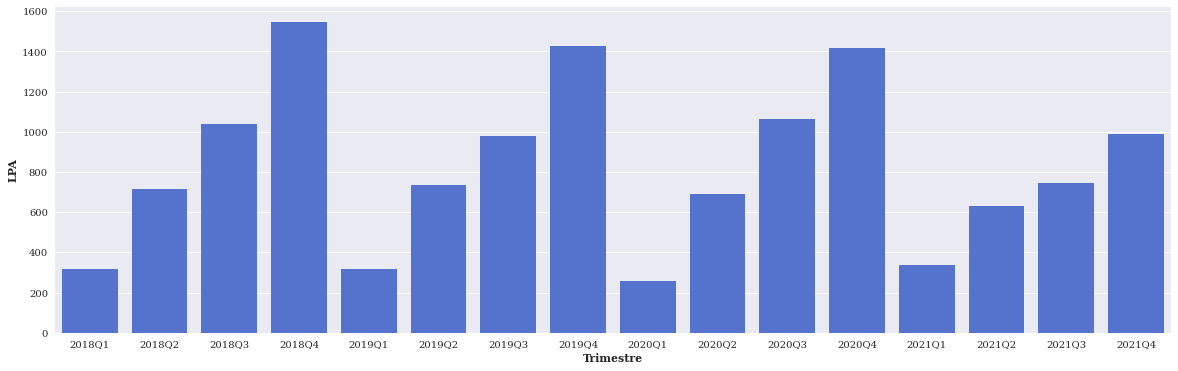

2) Testes de Hipótese
Estatísticas Descritivas - Pré-pandemia


,LPA
mean,880.513727
std,159.701752
min,555.466159
25%,769.938548
50%,860.125004
75%,971.307960
max,1325.746455


Estatísticas Descritivas - Pandemia


,LPA
mean,775.924743
std,137.681738
min,449.308190
25%,684.360100
50%,788.754730
75%,874.095265
max,1093.690334


,LPA,Teste,Estatística,Valor p
0,LPA,Teste t,5.114737,0.000002
1,LPA,Teste H,18.346405,0.000018



 MATERIAIS BÁSICOS
1) LPA Setorial


,LPA
DT_REFER,
2018Q1,75.771672
2018Q2,-98.938827
2018Q3,-94.587798
2018Q4,34.939901
2019Q1,-94.803594
2019Q2,-1.088459
2019Q3,-179.612607
2019Q4,-207.660454
2020Q1,691.552515


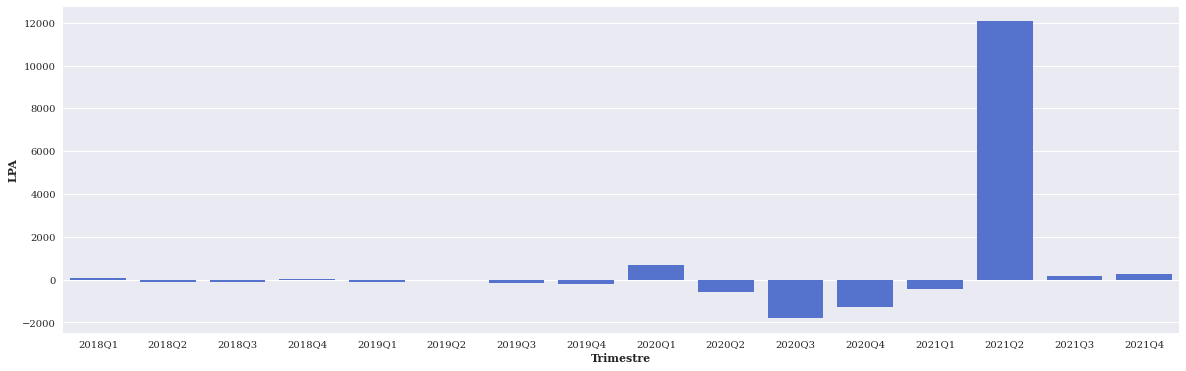

2) Testes de Hipótese
Estatísticas Descritivas - Pré-pandemia


,LPA
mean,-72.926280
std,35.485362
min,-187.058289
25%,-92.490613
50%,-72.319840
75%,-51.121756
max,15.423226


Estatísticas Descritivas - Pandemia


,LPA
mean,1100.252858
std,1324.674805
min,-1028.897508
25%,-227.123797
50%,1179.706613
75%,2397.285741
max,4403.191133


,LPA,Teste,Estatística,Valor p
0,LPA,Teste t,-8.866525,0.0
1,LPA,Teste H,22.123134,0.000003



 PETRÓLEO. GÁS E BIOCOMBUSTÍVEIS
1) LPA Setorial


,LPA
DT_REFER,
2018Q1,198.995961
2018Q2,1345.892727
2018Q3,2743.085658
2018Q4,5474.430897
2019Q1,108.088038
2019Q2,300.158294
2019Q3,1177.069834
2019Q4,2667.547173
2020Q1,-1864.835700


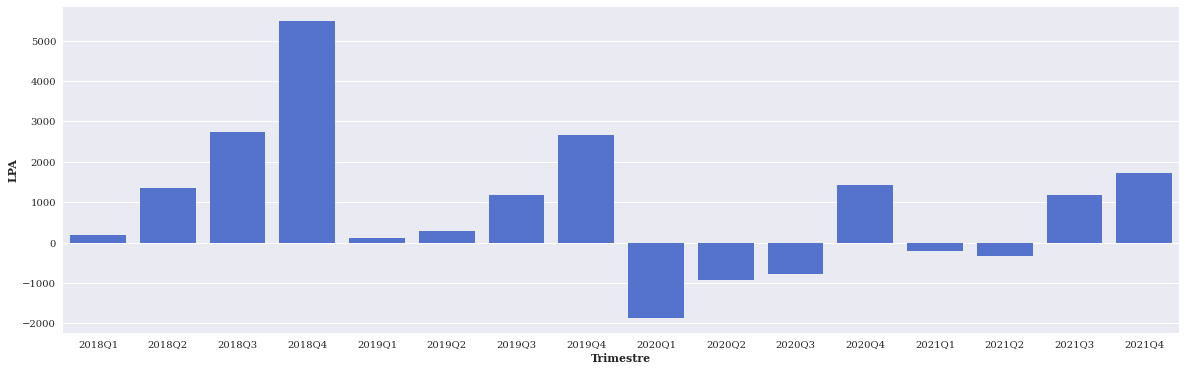

2) Testes de Hipótese
Estatísticas Descritivas - Pré-pandemia


,LPA
mean,1708.795649
std,629.536192
min,664.214673
25%,1146.551978
50%,1736.116532
75%,2128.217976
max,3156.006442


Estatísticas Descritivas - Pandemia


,LPA
mean,-18.901132
std,377.800492
min,-1047.004497
25%,-261.759722
50%,-24.663217
75%,234.134351
max,1011.017021


,LPA,Teste,Estatística,Valor p
0,LPA,Teste t,23.17609,0.0
1,LPA,Teste H,147.943521,0.0



 SAÚDE
1) LPA Setorial


,LPA
DT_REFER,
2018Q1,364.288558
2018Q2,688.860315
2018Q3,987.636389
2018Q4,1371.742717
2019Q1,337.756336
2019Q2,669.454003
2019Q3,1049.361232
2019Q4,1149.571183
2020Q1,19.141418


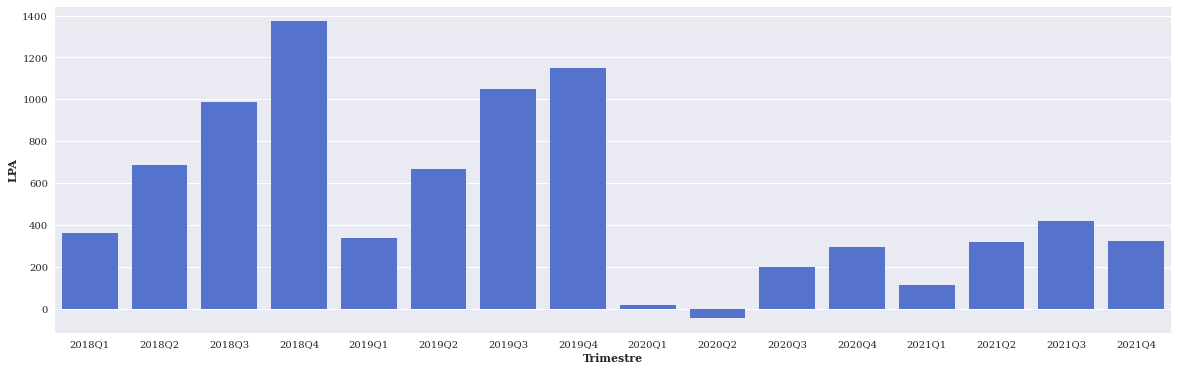

2) Testes de Hipótese
Estatísticas Descritivas - Pré-pandemia


,LPA
mean,827.744712
std,111.926755
min,432.165386
25%,775.700394
50%,823.715628
75%,897.711940
max,1066.743824


Estatísticas Descritivas - Pandemia


,LPA
mean,211.561109
std,53.931399
min,52.834813
25%,171.560841
50%,206.480388
75%,255.457337
max,343.296959


,LPA,Teste,Estatística,Valor p
0,LPA,Teste t,49.676309,0.0
1,LPA,Teste H,149.253731,0.0



 TECNOLOGIA DA INFORMAÇÃO
1) LPA Setorial


,LPA
DT_REFER,
2018Q1,127.471504
2018Q2,260.028536
2018Q3,399.138974
2018Q4,258.028453
2019Q1,170.336735
2019Q2,377.834637
2019Q3,686.270725
2019Q4,742.773561
2020Q1,198.623904


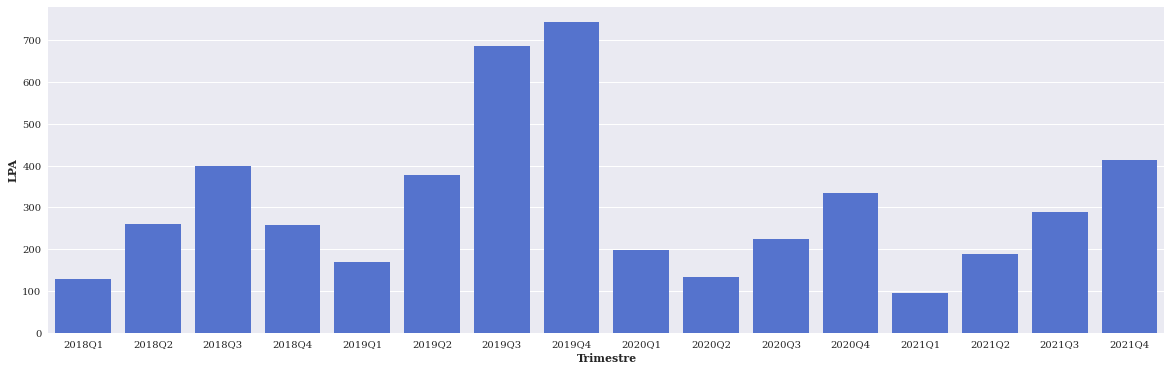

2) Testes de Hipótese
Estatísticas Descritivas - Pré-pandemia


,LPA
mean,386.024426
std,77.838037
min,252.900514
25%,326.450979
50%,381.863135
75%,429.670281
max,668.054714


Estatísticas Descritivas - Pandemia


,LPA
mean,240.497023
std,32.555364
min,165.901915
25%,216.915430
50%,241.345994
75%,262.211085
max,319.221177


,LPA,Teste,Estatística,Valor p
0,LPA,Teste t,16.39884,0.0
1,LPA,Teste H,139.161696,0.0



 UTILIDADE PÚBLICA
1) LPA Setorial


,LPA
DT_REFER,
2018Q1,219.874584
2018Q2,457.821110
2018Q3,700.496334
2018Q4,1150.850365
2019Q1,312.567799
2019Q2,441.668272
2019Q3,1228.469677
2019Q4,1511.422981
2020Q1,292.323817


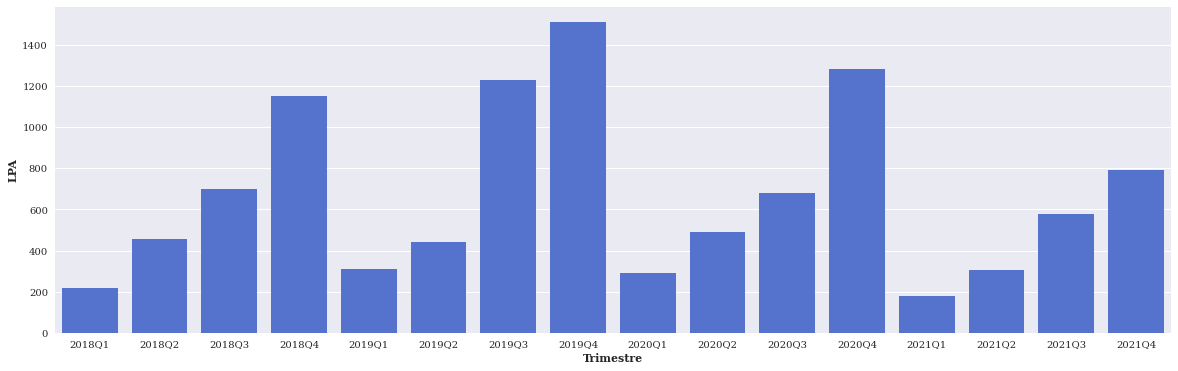

2) Testes de Hipótese
Estatísticas Descritivas - Pré-pandemia


,LPA
mean,766.704405
std,159.372520
min,332.868922
25%,659.211187
50%,776.441731
75%,878.457224
max,1164.753371


Estatísticas Descritivas - Pandemia


,LPA
mean,577.410501
std,108.009264
min,318.950457
25%,498.659810
50%,565.890341
75%,660.905527
max,823.590946


,LPA,Teste,Estatística,Valor p
0,LPA,Teste t,9.457777,0.0
1,LPA,Teste H,65.60751,0.0


In [51]:
setores = lista_setores()

for nome in list(setores.keys()):
    try:
        print('\n', nome.upper())
        setor = setores[nome]

        print('1) LPA Setorial')
        lpa_setorial = calcula_lpa_setorial(dfcs, setor, nome=nome)
        lpa_setorial = lpa_setorial['2018-01-01':]
        display(lpa_setorial)

        plot_lpa(lpa_setorial, nome=nome)
        
        print('2) Testes de Hipótese')
    
        lpa_stats = calcula_lpa_teste_bootstrap(lpa_setorial, nome=nome)
        display(lpa_stats)
    except:
        pass

In [59]:
def calcula_LPA(setores):
    LPA = pd.DataFrame(columns = ['Setor Econômico', 'Período', 'LPA'])
    for nome in list(setores.keys()):
        try:
            for periodo in ['Pré-pandemia', 'Pandemia']:
                df = pd.read_csv(os.path.join(ROOT_DIR, 'data', 'indicadores', f'lpa_{secure_name(nome)}_{secure_name(periodo)}_stats.csv'), index_col=0)
                lpa = df.loc['mean']['LPA']
                tmp_df = pd.DataFrame([nome, periodo, lpa]).T
                tmp_df.columns = ['Setor Econômico', 'Período', 'LPA']
                LPA = pd.concat([LPA, tmp_df])
        except:
            pass

    LPA.reset_index(drop=True, inplace=True)
    return LPA

In [61]:
LPA = calcula_LPA(setores)
LPA = LPA[LPA['Setor Econômico']!='Consumo Cíclico']
LPA

,Setor Econômico,Período,LPA
0,Bens Industriais,Pré-pandemia,-1083.657103
1,Bens Industriais,Pandemia,-209.218801
4,Consumo não Cíclico,Pré-pandemia,282.423417
5,Consumo não Cíclico,Pandemia,1296.067713
6,Financeiro,Pré-pandemia,880.513727
7,Financeiro,Pandemia,775.924743
8,Materiais Básicos,Pré-pandemia,-72.92628
9,Materiais Básicos,Pandemia,1100.252858
10,Petróleo. Gás e Biocombustíveis,Pré-pandemia,1708.795649
11,Petróleo. Gás e Biocombustíveis,Pandemia,-18.901132


In [ ]:
LPA = calcula_LPA(setores)
LPA = LPA[LPA['Setor Econômico']!='Consumo Cíclico']
grouped = LPA.groupby('Setor Econômico')
pandemia = grouped['LPA'].last()
pandemia = pandemia.to_list()
lst_pan = []
for p in pandemia:
    lst_pan.append(p)
    lst_pan.append(p)

LPA['Pan'] = lst_pan
tmp = LPA.sort_values(['Pan', 'Período'], ascending=False)
fig, ax = plt.subplots(figsize=(14, 6))
sns.barplot(data=tmp, x = 'LPA', y = 'Setor Econômico', hue='Período')
#ax.axvline(1, color='red', alpha=.5, linestyle='dashed')

ax.set_xlabel('Lucro por ação (R$/nº de ações)', fontweight='bold', fontsize=14)
ax.set_ylabel('Setor Econômico', fontweight='bold', fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=13)
plt.legend(prop={'size': 13})

plt.savefig(os.path.join(ROOT_DIR, 'img', 'indicadores', 'lpa_setores.png'), bbox_inches='tight')
plt.show()